<a href="https://colab.research.google.com/github/aubricot/CV_for_flower_CT/blob/main/Cacao_Whole_Flower_Seg_unetr_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using MONAI Label for shape prediction of flowers from micro-CT images
---   
*Last Updated 31 Mar 2023*  
-Runs in Python 3 with Monai 1.5-   
This notebook uses a dataset of micro-CT images and segementations (both as nifti files, .nii.gz) to custom train a UNETR Computer Vision Model ([Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)) using the [MONAI Label](https://github.com/aubricot/computer_vision_with_eol_images/tree/master/classification_for_image_tagging) framework. U-Nets are a type of Convolutional Neural Network (CNN) shaped like a "U" with pairings of encoders (contracting path) and decoders (expanding path) who have gained popularity in recent years as a tool for segmentation of 3D image datasets ([Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)). UNETR has a similar network design/shape for the encoder and decoder as a U-Net, but UNET TRansformers (UNETR), uses a transformer as the encoder.

_References_

* [Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)   
* [Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)

_License_   
This notebook is licensed under an [MIT license](https://github.com/aubricot/CV_for_flower_CT/blob/master/LICENSE). Portions are modified from the MONAI Label [3D Multi-organ Segmentation with UNETR (BTCV Challenge)](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb) following licensing terms under Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0).

The sections "Make sure runtime is set to GPU and High RAM," "Train pipeline," and "Plot train Loss and mean DICE and save results to file" were modified from 3D Multi-organ Segmentation with UNETR (BTCV Challenge) to better suit our needs. Google Colab form fields were also added, as well as tools to split the dataset train-validate-test, methods to save training outputs (trained models, notebook in its state for each train run as a txt file, and train graphs; named based on the train attempt number (ie the first train attempt files were saved as 01.ph, 01.txt, and 01.png).

## Installs & Imports
---

In [1]:
#@title Make sure runtime is set to GPU and High RAM
# Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Mar 31 16:52:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#@title Check how many workers are suggested for your system
# TO DO: Adjust num_workers throughout code to speed or slow performance based on available (cloud) hardware
import os

cpu_count = os.cpu_count()
if cpu_count is not None:
    max_num_worker_suggest = cpu_count

print("Suggested max number of workers is: ", max_num_worker_suggest)

Suggested max number of workers is:  12


In [3]:
#@title Choose where to save results

# Use dropdown menu on right
save = "in my Google Drive" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Type in the path to your project wd in form field on right
wd = "/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data" # @param ["/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data","/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/demo_data/Abdomen/Abdomen/RawData/data"] {"allow-input":true}
print("Working with data from: \n")
%cd $wd

Mounted at /content/drive
Working with data from: 

/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data


In [ ]:
#@title Only run once during initial setup: Unzip dataset converted and zipped with preprocessing_nrrd2nifti.ipynb
# Enter wd, zip and unzipped filenames using form field to right
wd = "/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input" #@param ["/content/drive/MyDrive"] {allow-input: true}
zip_fn = "nii_gzs5_masked.zip" #@param ["PlantCLEF2015TrainingData_2.zip"] {allow-input: true}
zip_fpath = wd + '/' + zip_fn
unzipped_fn = "nii_gzs5_masked" #@param ["images"] {allow-input: true}
unzipped_fpath = wd + '/' + unzipped_fn

# Unzip the file/folder
!unzip $zip_fpath -d $unzipped_fpath

In [4]:
#@title Installs
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install nbconvert
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 95.4 MB/s eta 0:00:00


In [5]:
#@title Imports
import os
import shutil
import tempfile
import glob
import math
import time

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.utils import first
from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureType,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNETR, unet
from torch.optim import Adam, SGD
from monai.optimizers import Novograd
from monai.apps import download_and_extract
from monai.data import NibabelReader

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    ThreadDataLoader,
    Dataset,
    set_track_meta,
)

# Facilitate debugging by making GPU tell more useful information
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

# Check that cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available and being used.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU instead.")

print_config()

CUDA is available and being used.
MONAI version: 1.5.dev2513
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ef083a32ccc13ee3937a4bd8acc12b9cdc174e18
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, pleas

In [6]:
#@title Set up data directory
os.environ['MONAI_DATA_DIRECTORY'] = wd
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = directory
print(f"root dir is: {root_dir}")

out_dir = wd + '/' + "results/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

print(f"out dir is: {out_dir}")

root dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data
out dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/


In [7]:
#@title Define functions

# Save each new training attempt results by name (TRAIN_SES_NUM)
def set_saved_model_path(out_dir = out_dir, saved_models_dir = "saved_models"):
    saved_models_wd = os.path.join(out_dir, saved_models_dir)
    if not os.path.exists(saved_models_wd):
        print("{} not found. Making saved models directory at: {}".format(saved_models_dir, saved_models_wd))
        os.mkdir(saved_models_wd)
    # Name folder to sort by attempt number (useful if many training runs)
    else:
        try:
            last_attempt = !ls $saved_models_wd | tail -n 1
            last_attempt = int(os.path.splitext(last_attempt[0])[0])
        except:
            last_attempt = 0
        if last_attempt < 9:
            TRAIN_SESS_NUM = "0" + str(last_attempt + 1)
        else:
            TRAIN_SESS_NUM = str(last_attempt + 1)

    saved_model_path = os.path.join(saved_models_wd, (TRAIN_SESS_NUM + ".pth"))
    print("Saving trained model results to: ", saved_model_path)

    return saved_model_path, TRAIN_SESS_NUM

# For pulling img and label file names from train/val dictionaries
def find_dict_idx_by_val(dict_list, key, val):
    for idx, dict in enumerate(dict_list):
        if key in dict and val in dict[key]:
            return idx

## Only run once during inital dataset setup: Train-test-validation split

In [ ]:
#@title Train-test-validation split
!pip install split-folders
import splitfolders

# List all files in dir before splitting
all_vols = os.listdir('./images/class1')
n = len(all_vols)
print("Training dataset size of N = ", n)

# Save list of files before split to txt file in your wd
with open("all_vols.txt", "w") as output:
    output.write(str(all_vols))
print("List of all files before splitting saved to: ", (wd + '/all_vols.txt'))

# Train-test-validation split (70% - 15% - 15%)
splitfolders.ratio("images", output="input", seed=n,
                   ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False)

In [ ]:
#@title Move labels to their corresponding train-test-val folders to match images

# Get list of all labels
all_labs = os.listdir('./labels/class1')
all_labs = [os.path.splitext(os.path.splitext(file)[0])[0] for file in all_labs] # Remove .nii.gz extensions
all_labs = [file.removesuffix('_seg') for file in all_labs]

# Find which label files need to be moved to train-test-val and move them
train = os.listdir('./input/train/class1')
train = [os.path.splitext(os.path.splitext(file)[0])[0] for file in train] # Remove .nii.gz extensions
train = [file.removesuffix('_crop') for file in train]
train = [file.removesuffix('_cropped') for file in train]
train = [file.removesuffix('_crop_mask') for file in train]

test = os.listdir('./input/test/class1')
test = [os.path.splitext(os.path.splitext(file)[0])[0] for file in test] # Remove .nii.gz extensions
test = [file.removesuffix('_crop') for file in test]
test = [file.removesuffix('_cropped') for file in test]
test = [file.removesuffix('_crop_mask') for file in test]

val = os.listdir('./input/val/class1')
val = [os.path.splitext(os.path.splitext(file)[0])[0] for file in val] # Remove .nii.gz extensions
val = [file.removesuffix('_crop') for file in val]
val = [file.removesuffix('_cropped') for file in val]
val = [file.removesuffix('_crop_mask') for file in val]

train_mv = set(train) & set(all_labs)
test_mv = set(test) & set(all_labs)
val_mv = set(val) & set(all_labs)

# Move files to train
os.makedirs('input/train/class1/labels')
for file in train_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/train/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move files to test
os.makedirs('input/test/class1/labels')
for file in test_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/test/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move files to validation (val)
os.makedirs('input/val/class1/labels')
for file in val_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/val/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move all image files within train-test-val into images/
target = 'input/train/class1/images'
os.makedirs(target)
source = './input/train/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

target = 'input/test/class1/images'
os.makedirs(target)
source = './input/test/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

target = 'input/val/class1/images'
os.makedirs(target)
source = './input/val/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

## Transform datasets for training and validation

In [8]:
#@title Get dataset filepaths for train and validation
data_root = os.path.join(root_dir, "input")

train_images = sorted(glob.glob(os.path.join(data_root, "train/images", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "train/labels", "*.nii.gz")))
val_images = sorted(glob.glob(os.path.join(data_root, "val/images", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_root, "val/labels", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
num_train = len(train_files)
num_val = len(val_files)

print("Training model with {} train images and {} validation images\n".format(num_train, num_val))
print(" Train images loaded from {} \n Train labels loaded from {} \n Validation images loaded from {} \n Validation labels loaded from {}".format(train_images, train_labels, val_images, val_labels))

Training model with 14 train images and 3 validation images

 Train images loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THECAC_FBG_RF_220502_05_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/Thecac_usda_MIA_SHRS7_220331_01_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/thecac_fbg_cg_220622_01_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/thecac_fbg_cg_220622_02_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/thecac_fbg_cg_220622_03_crop_mask.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/thecac_fbg_cg_220622_06_masked.nii.gz', '/content/drive/MyDrive/Miami_21/project/ma

In [9]:
#@title Dataset Transforms

# use clip with ScaleIntensityRangePercentilesd?
clip = False # @param {"type":"boolean"}
relative = False # @param {"type":"boolean"}

# Weights of pos vs neg labels for RandCropByPosNegLabeld
pos = 1 #@param
neg = 1 #@param

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),),
        ScaleIntensityRangePercentilesd(
                keys="image",
                lower=10, upper=90, b_min=0, b_max=200,
                clip=clip,
                relative=relative,),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=pos, # 1 to 1 ratio pos:neg applies equal weight; since binary problem, apply more weight to pos
            neg=neg,
            num_samples=4,
            image_key="image",
            image_threshold=0,),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),),
        ScaleIntensityRangePercentilesd(
                keys="image",
                lower=10, upper=90, b_min=0, b_max=200,
                clip=clip,
                relative=relative,),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [10]:
#@title Transform datasets and read into cache for training

# Train Dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_num=num_train, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=6, pin_memory=True)

# Validation Dataset
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=num_val, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

print("\n\nSample Validation image shape after transform: {}, label shape: {}".format(first(val_loader)['image'].shape, first(val_loader)['label'].shape))
print("\n\nSample Train image shape after transform: {}, label shape: {}".format(first(train_loader)['image'].shape, first(train_loader)['label'].shape))

Loading dataset:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/transforms/intensity/array.py:1000: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
Loading dataset: 100%|██████████| 3/3 [00:29<00:00,  9.76s/it]




Sample Validation image shape after transform: torch.Size([1, 1, 173, 232, 285]), label shape: torch.Size([1, 1, 173, 232, 285])


Sample Train image shape after transform: torch.Size([4, 1, 96, 96, 96]), label shape: torch.Size([4, 1, 96, 96, 96])


In [11]:
#@title Inspect image and labels after transformation
import nibabel as nib

# Coordinate system (for Nifti it's RAS)
axcodes = "RAS" # @param ["RAS","PLI","LPS"] {"allow-input":true}

# Check transformed image shape and loading
load_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear")),
        ])

Visualizing image transforms for: thecac_fbg_rph_220622_15_masked.nii.gz ...

Original image shape:  torch.Size([1, 224, 242, 268])
Original label shape:  torch.Size([1, 224, 242, 268])
Transformed image shape:  torch.Size([1, 223, 242, 268])
Transformed label shape:  torch.Size([1, 223, 242, 268])


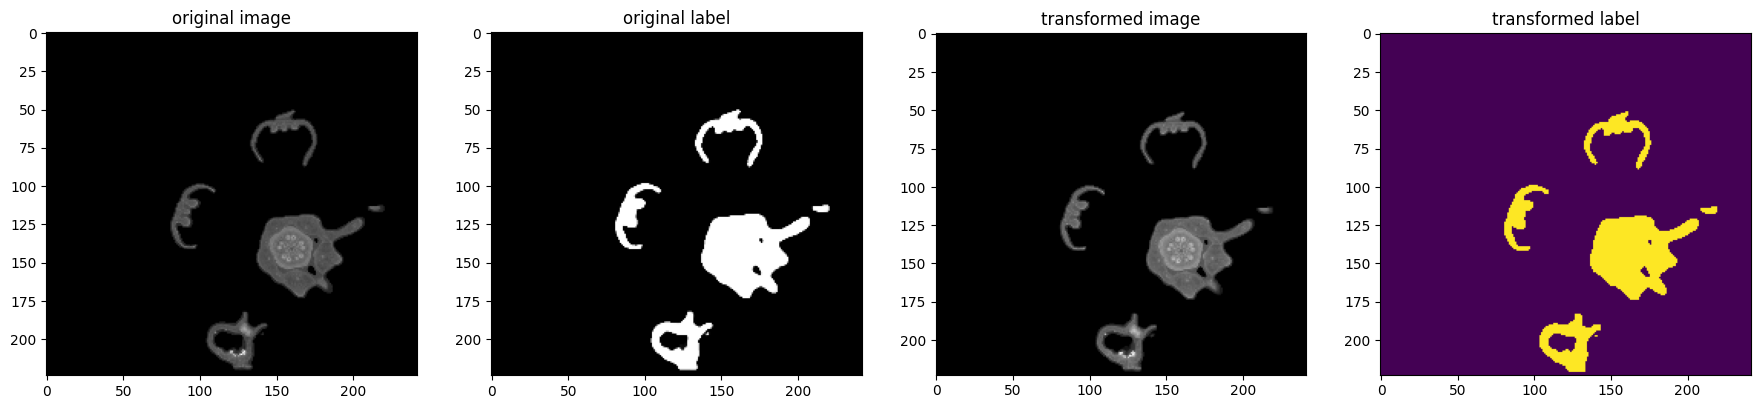

In [12]:
#@title Set val image index and slice number to visualize

img_idx = 2 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 148 # @param {"type":"slider","min":0,"max":500,"step":1}

with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[img_idx]['image'].meta["filename_or_obj"])[1]
    print("Visualizing image transforms for: {} ...\n".format(img_name))

    # Get original image and label info
    img_path = data_root + '/val/images/' + img_name
    # Workaround for _crop in image filenames not in labels
    if '_crop' in img_name:
        img_name = str.split(img_name, '_crop')[0]
    idx = find_dict_idx_by_val(val_files, 'image', img_name)
    orig_data = load_transform(val_files[idx])
    orig_img = orig_data["image"]
    print("Original image shape: ", orig_img.shape)
    orig_label = orig_data["label"]
    print("Original label shape: ", orig_label.shape)

    # Get transformed image and label info
    img = val_ds[img_idx]["image"]
    label = val_ds[img_idx]["label"]
    print("Transformed image shape: ", img.shape)
    print("Transformed label shape: ", label.shape)

    # Plot images
    plt.figure("Orig vs Transformed", (22, 6))
    plt.subplot(1, 4, 1)
    plt.title("original image")
    plt.imshow(orig_img.numpy()[0, :, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title("original label")
    plt.imshow(orig_label.numpy()[0, :, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 3)
    plt.title("transformed image")
    plt.imshow(img.cpu().numpy()[0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 4, 4)
    plt.title("transformed label")
    plt.imshow(label.cpu().numpy()[0, :, :, slice_num])

    plt.show()

## Train

In [13]:
#@title Set model parameters

# Use cuda GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# How many epochs to train for and how often to evaluate model performance
max_iterations = 500 #@param
eval_num = 20 #@param

# Parameters
out_channels = 1 #@param
img_size = 96 #@param
feature_size = 32 # @param ["16","32","48","64","70","96"] {"type":"raw"}
hidden_size = 768 #@param
mlp_dim = 3072 #@param
num_heads = 12 #@param
norm_name = "instance" # @param ["instance","batch"]
res_block = True # @param {"type":"boolean"}
conv_block = True # @param {"type":"boolean"}
dropout_rate = 0.0 #@param
pos_embed = "perceptron" # @param ["conv","perceptron"]

# Define the model
model = UNETR(
    in_channels=1,
    out_channels=out_channels,
    img_size=(img_size, img_size, img_size),
    feature_size=feature_size,
    hidden_size=hidden_size,
    mlp_dim=mlp_dim,
    num_heads=num_heads,
    norm_name=norm_name,
    conv_block=conv_block,
    res_block=res_block,
    dropout_rate=dropout_rate,
    proj_type=pos_embed,
).to(device)

# Get model architecture info for pubs, etc
#print(len(model.model))
#print(model)

# Define the loss function
if out_channels > 1:
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
else:
    loss_function = DiceCELoss(include_background=False, sigmoid=True)

# Algorithmically optimize GPU training and speed things up, could be variable for val images since size varies
torch.backends.cudnn.benchmark = True #@param

# Set optimizer parameters
optimizer = "AdamW" # @param ["AdamW","Novograd"] {"allow-input":true}
lr = 0.8e-6 # @param ["1.5e-3","1e-3"] {"type":"raw","allow-input":true}
weight_decay = 2e-3 # @param ["1e-2","0","1e-3","1e-4","1e-1"] {"type":"raw","allow-input":true}
amsgrad = False # @param {"type":"boolean"}
if "Adam" in optimizer:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)
else:
    optimizer = Novograd(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)

Computing optimal learning rate:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/losses/dice.py:175: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
Computing optimal learning rate:  50%|█████     | 10/20 [00:16<00:16,  1.69s/it]


Stopping early, the loss has diverged
Resetting model and optimizer


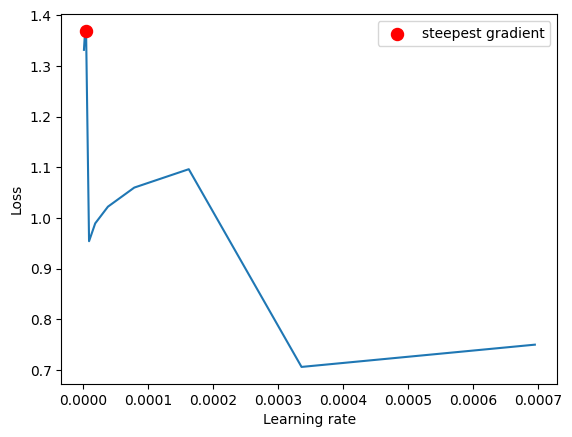

Steepest gradient found at:  (4.2813323987193935e-06, 1.3689554077386856)


In [15]:
#@title Find optimal learning rate based on model parameters
from monai.optimizers import LearningRateFinder

# Define lower and upper learning rates to inspect
lower_lr, upper_lr = 1e-6, 1
# Add lower_lr to optimizer
#optimizer = Novograd(model.parameters(), lr=lower_lr, weight_decay=weight_decay, amsgrad=amsgrad)
optimizer = torch.optim.AdamW(model.parameters(), lr=lower_lr, weight_decay=weight_decay, amsgrad=amsgrad)

# Find optimal learning rate
criterion = loss_function
optimizer = optimizer
lr_finder = LearningRateFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=upper_lr, num_iter=20)
lr_finder.get_steepest_gradient()
lr_finder.plot(log_lr=False)

print("Steepest gradient found at: ", lr_finder.get_steepest_gradient())

In [16]:
#@title Train pipeline
# Modified from : Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Save each new training attempt results by name (TRAIN_SES_NUM)
saved_models_dir = "saved_models" # @param ["saved_models"] {"allow-input":true}
saved_model_path, TRAIN_SESS_NUM = set_saved_model_path(out_dir, saved_models_dir)

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            #print("\nValidation input shape: ", val_inputs.shape)
            #print("\nValidation ground truth shape: ", val_labels.shape)
            val_outputs = sliding_window_inference(val_inputs, roi_size=(img_size, img_size, img_size), sw_batch_size=4, predictor=model)
            #print("\nValidation output shape: ", val_outputs.shape)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            #print("Val output convert: ", val_output_convert)
            #print("Val labels convert: ", val_labels_convert)
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        #print("\nModel input shape: ", x.shape)
        logit_map = model(x)
        #print("\nModel output shape: ", logit_map.shape)
        #print("\nGround truth shape: ", y.shape)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), saved_model_path)
                print(
                    "\033[32m Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}\033[0m".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "\033[33mModel Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}\033[0m".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

post_label = Compose([AsDiscrete(n_classes=out_channels)])
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
dice_metric = DiceMetric(include_background=False, reduction="mean")
global_step = 0
dice_val_best = -0.1
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(saved_models_dir, saved_model_path)))

print(f"\n\n\n train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

Saving trained model results to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/saved_models/134.pth


Training (20 / 500 Steps) (loss=1.70676):  50%|█████     | 7/14 [00:08<00:14,  2.04s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.016458502039313316 Current Avg. Dice: 0.016458502039313316


Training (40 / 500 Steps) (loss=1.65750):  93%|█████████▎| 13/14 [00:10<00:01,  1.90s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.01832663267850876 Current Avg. Dice: 0.01832663267850876


Training (60 / 500 Steps) (loss=1.70704):  36%|███▌      | 5/14 [00:07<00:19,  2.17s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.020653076469898224 Current Avg. Dice: 0.020653076469898224


Training (80 / 500 Steps) (loss=-12.96636):  79%|███████▊  | 11/14 [00:09<00:05,  1.81s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.02295764535665512 Current Avg. Dice: 0.02295764535665512


Training (100 / 500 Steps) (loss=1.70613):  21%|██▏       | 3/14 [00:06<00:30,  2.79s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.025548502802848816 Current Avg. Dice: 0.025548502802848816


Training (120 / 500 Steps) (loss=1.69437):  64%|██████▍   | 9/14 [00:09<00:09,  1.94s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.0280790813267231 Current Avg. Dice: 0.0280790813267231


Training (140 / 500 Steps) (loss=2.56843):   7%|▋         | 1/14 [00:07<01:31,  7.06s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.030713992193341255 Current Avg. Dice: 0.030713992193341255


Training (160 / 500 Steps) (loss=1.57374):  50%|█████     | 7/14 [00:08<00:13,  1.95s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.0333150252699852 Current Avg. Dice: 0.0333150252699852


Training (180 / 500 Steps) (loss=-10.42881):  93%|█████████▎| 13/14 [00:10<00:01,  1.87s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.03566351905465126 Current Avg. Dice: 0.03566351905465126


Training (200 / 500 Steps) (loss=1.66251):  36%|███▌      | 5/14 [00:08<00:21,  2.35s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.03773443400859833 Current Avg. Dice: 0.03773443400859833


Training (220 / 500 Steps) (loss=1.73397):  79%|███████▊  | 11/14 [00:10<00:05,  1.97s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.04009339213371277 Current Avg. Dice: 0.04009339213371277


Training (240 / 500 Steps) (loss=1.71254):  21%|██▏       | 3/14 [00:07<00:32,  2.96s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.042654700577259064 Current Avg. Dice: 0.042654700577259064


Training (260 / 500 Steps) (loss=-8.04419):  64%|██████▍   | 9/14 [00:09<00:09,  1.88s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.04430880397558212 Current Avg. Dice: 0.04430880397558212


Training (280 / 500 Steps) (loss=-18.62720):   7%|▋         | 1/14 [00:06<01:26,  6.68s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.04636699706315994 Current Avg. Dice: 0.04636699706315994


Training (300 / 500 Steps) (loss=1.66672):  50%|█████     | 7/14 [00:08<00:14,  2.06s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.04825262725353241 Current Avg. Dice: 0.04825262725353241


Training (320 / 500 Steps) (loss=1.62210):  93%|█████████▎| 13/14 [00:10<00:01,  1.88s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.049454543739557266 Current Avg. Dice: 0.049454543739557266


Training (340 / 500 Steps) (loss=1.55254):  36%|███▌      | 5/14 [00:08<00:21,  2.35s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.05091926455497742 Current Avg. Dice: 0.05091926455497742


Training (360 / 500 Steps) (loss=1.76177):  79%|███████▊  | 11/14 [00:09<00:05,  1.83s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.05229461193084717 Current Avg. Dice: 0.05229461193084717


Training (380 / 500 Steps) (loss=-24.14866):  21%|██▏       | 3/14 [00:07<00:32,  2.94s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.0536385141313076 Current Avg. Dice: 0.0536385141313076


Training (400 / 500 Steps) (loss=1.70247):  64%|██████▍   | 9/14 [00:09<00:09,  1.87s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.055020615458488464 Current Avg. Dice: 0.055020615458488464


Training (420 / 500 Steps) (loss=-16.49471):   7%|▋         | 1/14 [00:06<01:29,  6.88s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.055936966091394424 Current Avg. Dice: 0.055936966091394424


Training (440 / 500 Steps) (loss=1.70451):  50%|█████     | 7/14 [00:08<00:14,  2.06s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.05690998211503029 Current Avg. Dice: 0.05690998211503029


Training (460 / 500 Steps) (loss=-10.35005):  93%|█████████▎| 13/14 [00:10<00:01,  1.88s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.05781789869070053 Current Avg. Dice: 0.05781789869070053


Training (480 / 500 Steps) (loss=1.59685):  36%|███▌      | 5/14 [00:08<00:20,  2.33s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.058651480823755264 Current Avg. Dice: 0.058651480823755264


Training (500 / 500 Steps) (loss=-17.13133):  79%|███████▊  | 11/14 [00:09<00:05,  1.86s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.05915713310241699 Current Avg. Dice: 0.05915713310241699


Training (503 / 500 Steps) (loss=1.62646): 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]





 train completed, best_metric: 0.0592 at iteration: 500


In [17]:
#@title Convert notebook to txt file and save for track record of train parameters for each saved model

# Define train notebooks dir
train_nbs_path = "train_notebooks"
train_nbs_dir = os.path.join(out_dir, train_nbs_path)
if not os.path.exists(train_nbs_dir):
    os.mkdir(train_nbs_dir)


# Save train notebook to text file
train_nb_path = train_nbs_dir + '/' + str(TRAIN_SESS_NUM)

# Original train notebook (.ipynb) location
orig_nb_dir = "/content/drive/MyDrive/'Colab Notebooks'/" # @param ["/content/drive/MyDrive/'Colab Notebooks'/"] {"allow-input":true}
fn = "Cacao_Whole_Flower_Seg_unetr.ipynb" # @param ["Whole_Flower_Seg_unetr_newpipeline_abdomendata.ipynb"] {"allow-input":true}
fpath = orig_nb_dir + fn

# Convert train notebook to text file
%cd $orig_nb_dir
!jupyter nbconvert --output-dir=$train_nb_path --to python $fpath

print("Colab notebook: {} converted to text file: {} for use as train parameters log".format(fpath, train_nb_path))

/content/drive/MyDrive/Colab Notebooks
[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Cacao_Whole_Flower_Seg_unetr.ipynb' matched no files
[NbConvertApp] Making directory /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/train_notebooks/134
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config

Train graphs saved to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/train_graphs/134.png


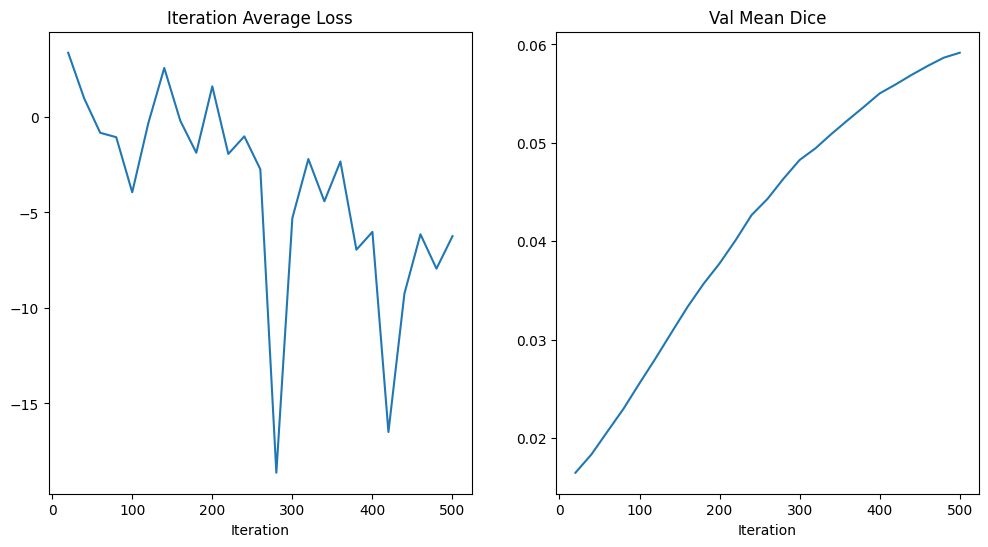

In [18]:
#@title Plot train Loss and mean DICE and save results to file
# Modified from : Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Plot figures
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)

# Define train graphs dir
train_graphs_dir = os.path.join(out_dir, "train_graphs/")
if not os.path.exists(train_graphs_dir):
    os.mkdir(train_graphs_dir)

# Save train graph to file
train_graph_path = train_graphs_dir + TRAIN_SESS_NUM + '.png'
plt.savefig(train_graph_path)
print("Train graphs saved to: ", train_graph_path)

# Display the plot
plt.show()

## Inspect Results

torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])
torch.Size([1, 1, 173, 232, 285])


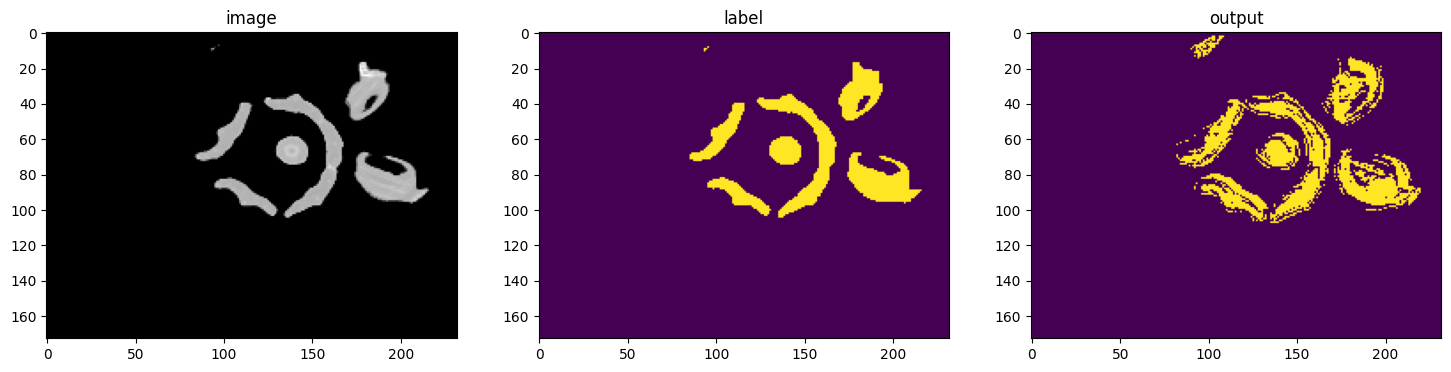

In [19]:
#@title Plot model prediction vs ground truth

val_img_idx = 0 # @param {"type":"slider","min":0,"max":2,"step":1}
slice_num = 147 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "38" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()